In [1]:
import pandas as pd
import numpy as np
import wrangle
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LassoLars
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import TweedieRegressor

from pydataset import data
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('zillow_data.csv')


In [3]:

df.head()
df = wrangle.preparing_data_zillow(df)

In [4]:
df.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
4,4.0,2.0,3633,296425.0,2005,6941.39,6037
6,3.0,4.0,1620,847770.0,2011,10244.94,6037
7,3.0,2.0,2077,646760.0,1926,7924.68,6037
11,0.0,0.0,1200,5328.0,1972,91.60,6037
14,0.0,0.0,171,6920.0,1973,255.17,6037


In [5]:
train, validate, test = wrangle.split_data(df, 'taxvaluedollarcnt')

In [6]:
X_train = train.drop(columns = ['taxvaluedollarcnt','taxamount'])

X_validate = validate.drop(columns = ['taxvaluedollarcnt','taxamount'])

y_train = train.taxvaluedollarcnt

y_validate = validate.taxvaluedollarcnt

X_test = test.drop(columns = ['taxvaluedollarcnt','taxamount'])

y_test = test.taxvaluedollarcnt
X_train

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,yearbuilt,fips
1196984,3.0,1.0,1036,1947,6037
1563409,3.0,2.0,1878,1959,6037
486661,3.0,3.0,2430,1966,6037
328430,3.0,2.0,1605,1943,6037
654871,6.0,3.0,2700,1984,6059
...,...,...,...,...,...
225651,3.0,3.0,2289,2002,6059
741819,4.0,3.0,2837,1972,6059
1989492,3.0,2.5,1462,1976,6059
662013,2.0,2.0,1191,1949,6037


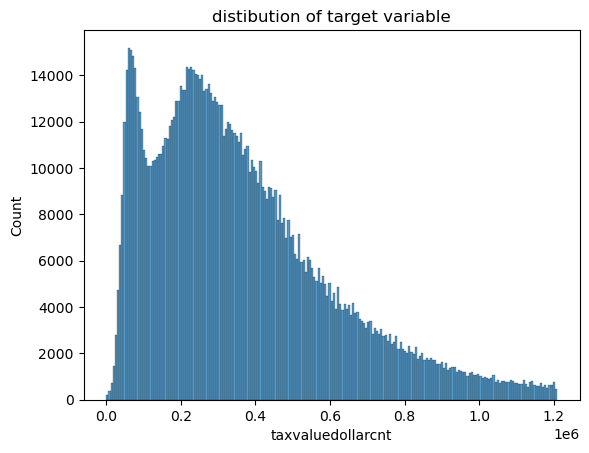

In [7]:
sns.histplot(y_train)
plt.title('distibution of target variable')
plt.show()

In [8]:
baseline = y_train.mean()
baseline

train.taxamount.nlargest()

2118845    100379.34
1930246     67715.45
1022867     50101.48
1808504     49888.35
1414893     40852.56
Name: taxamount, dtype: float64

In [9]:
def metrics_reg(y, yhat):
    '''
    send in y_true, y_pred and returns rmse, r2
    '''
    
    rmse = mean_squared_error(y, yhat, squared=False)
    r2 = r2_score(y, yhat)
    return rmse, r2

In [10]:
baseline_array = np.repeat(baseline, len(train))
baseline_array

array([363708.59601093, 363708.59601093, 363708.59601093, ...,
       363708.59601093, 363708.59601093, 363708.59601093])

In [11]:
rmse, r2 = metrics_reg(y_train, baseline_array)
rmse, r2

(243873.34821247822, 0.0)

In [12]:
metrics_df = pd.DataFrame(data=[
    {
        'model':'baseline',
        'rmse':rmse,
        'r2':r2
    }
])
metrics_df

,model,rmse,r2
0,baseline,243873.348212,0.0


In [13]:
lr1 = LinearRegression()

In [14]:
rfe = RFE(lr1, n_features_to_select=1)

In [15]:
rfe.fit(X_train, y_train)

RFE(estimator=LinearRegression(), n_features_to_select=1)

In [16]:
X_train_rfe = rfe.transform(X_train)

In [17]:
X_val_rfe = rfe.transform(X_validate)

In [18]:
print('selected top feature:', rfe.get_feature_names_out())

selected top feature: ['bathroomcnt']


In [19]:
lr1.fit(X_train_rfe, y_train)


LinearRegression()

In [20]:
pred_lr1 = lr1.predict(X_train_rfe)

In [21]:
pred_val_lr1 = lr1.predict(X_val_rfe)

In [22]:
rmse, r2 = metrics_reg(y_train, pred_lr1)

In [23]:
metrics_df.loc[1] = ['ols_1', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,243873.348212,0.000000
1,ols_1,217231.574258,0.206554


In [24]:
lr1.intercept_

79906.52841878869

In [25]:
lr1.coef_

array([132471.8368434])

In [26]:
print(f'taxamount = {lr1.intercept_:.3} + {lr1.coef_[0]:.2}*bathroomcnt')

taxamount = 7.99e+04 + 1.3e+05*bathroomcnt


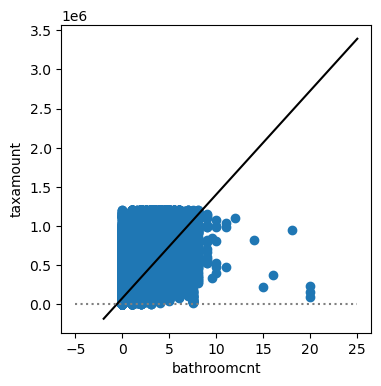

In [27]:
plt.figure(figsize=(4,4))
plt.scatter(train.bathroomcnt, train.taxvaluedollarcnt)
x_val = np.array([-2, 25]).reshape(-1,1)

plt.plot(x_val, lr1.intercept_ + x_val*lr1.coef_[0], c='black')

plt.hlines(22, -5, 25, ls= ':', color= 'grey')
plt.vlines(0, -10, 100, ls='--', color='grey')
plt.xlabel('bathroomcnt')
plt.ylabel('taxamount')
plt.show()

In [28]:
lr2 = LinearRegression()


In [29]:
lr2.fit(X_train, y_train)


LinearRegression()

In [30]:
pred_lr2 = lr2.predict(X_train)

In [31]:
pred_val_lr2 = lr2.predict(X_validate)

In [32]:
rmse, r2 = metrics_reg(y_train, pred_lr2)

In [33]:
metrics_df.loc[2] = ['ols', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,243873.348212,0.000000
1,ols_1,217231.574258,0.206554
2,ols,205388.273516,0.290712


In [34]:
lars = LassoLars(alpha= 0)

lars.fit(X_train, y_train)


LassoLars(alpha=0)

In [35]:
pred_lars = lars.predict(X_train)

In [36]:
pd.Series(lars.coef_, index = lars.feature_names_in_)

bedroomcnt                     -37080.568852
bathroomcnt                     38598.651219
calculatedfinishedsquarefeet      161.924496
yearbuilt                         367.528613
fips                              426.584364
dtype: float64

In [37]:
lars = LassoLars(alpha=1)
lars.fit(X_train, y_train)

LassoLars(alpha=1)

In [38]:
pred_lars = lars.predict(X_train)

In [39]:
pred_val_lars = lars.predict(X_validate)

In [40]:
rmse, r2 = metrics_reg(y_train, pred_lars)

In [41]:
metrics_df.loc[3] = ['lars', rmse, r2]

In [42]:
pf = PolynomialFeatures(degree=2)

In [43]:
X_train_degree2 = pf.fit_transform(X_train)

In [44]:
X_validate_degree2 = pf.transform(X_validate)

In [45]:
X_test_degree2 = pf.transform(X_test)

In [46]:
pr = LinearRegression()

In [47]:
pr.fit(X_train_degree2, y_train)

LinearRegression()

In [48]:
pred_pr = pr.predict(X_train_degree2)

In [49]:
pred_val_pr = pr.predict(X_validate_degree2)

In [50]:
rmse, r2 = metrics_reg(y_train, pred_pr)

In [51]:
rmse, r2

(202250.63909034032, 0.31221749672321264)

In [52]:
metrics_df.loc[4] = ['poly_2', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,243873.348212,0.000000
1,ols_1,217231.574258,0.206554
2,ols,205388.273516,0.290712
3,lars,205388.273537,0.290712
4,poly_2,202250.639090,0.312217


In [53]:
glm = TweedieRegressor(power=1, alpha=0)

In [54]:
glm.fit(X_train, y_train)

TweedieRegressor(alpha=0, power=1)

In [55]:
pred_glm = glm.predict(X_train)

In [56]:
pred_val_glm = glm.predict(X_validate)

In [57]:
rmse, r2 = metrics_reg(y_train, pred_glm)

In [58]:
rmse, r2

(243873.34821247822, -2.220446049250313e-16)

In [59]:
metrics_df.loc[5] = ['glm', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,243873.348212,0.000000e+00
1,ols_1,217231.574258,2.065543e-01
2,ols,205388.273516,2.907120e-01
3,lars,205388.273537,2.907120e-01
4,poly_2,202250.639090,3.122175e-01
5,glm,243873.348212,-2.220446e-16


# we want the highest R2 and lowest rmse

In [60]:
X_test_degree2 = pf.transform(X_test)

In [61]:
pred_pr_test = pr.predict(X_test_degree2)

In [62]:
rmse, r2 = metrics_reg(y_test, pred_pr_test)

In [63]:
metrics_df

,model,rmse,r2
0,baseline,243873.348212,0.000000e+00
1,ols_1,217231.574258,2.065543e-01
2,ols,205388.273516,2.907120e-01
3,lars,205388.273537,2.907120e-01
4,poly_2,202250.639090,3.122175e-01
5,glm,243873.348212,-2.220446e-16


In [64]:
X_train, X_validate, X_test, y_train, y_validate, y_test = wrangle.get_X_train_val_test(train,validate, test,x_target = ['taxvaluedollarcnt','taxamount'],y_target = 'taxvaluedollarcnt')

In [65]:
metrics_train_df, metrics_validate_df = wrangle.get_model_numbers(X_train, X_validate, X_test, y_train, y_validate, y_test)

In [66]:
metrics_train_df

,model_train,rmse,r2
0,baseline,243873.348212,0.000000e+00
1,ordinary least squared(OLS),205388.273516,2.907120e-01
2,lasso lars(lars),205388.273537,2.907120e-01
3,Polynomial Regression(poly2),202250.639090,3.122175e-01
4,Generalized Linear Model (GLM),243873.348212,-2.220446e-16


In [67]:
metrics_validate_df

,model_validate,rmse,r2
0,baseline,243873.348212,0.000000
1,ordinary least squared(OLS),205253.397684,0.290081
2,lasso lars(lars),205253.393497,0.290081
3,Polynomial Regression(poly2),202206.502795,0.311002
4,Generalized Linear Model (GLM),243605.945613,-0.000008


In [68]:
X_train, X_validate, X_test = wrangle.scaler_robust(X_train, X_validate, X_test)

In [75]:
X_train

array([[0.2       , 0.05      , 0.04273504, 0.67906977, 0.        ],
       [0.2       , 0.1       , 0.07750114, 0.73488372, 0.        ],
       [0.2       , 0.15      , 0.10029316, 0.76744186, 0.        ],
       ...,
       [0.2       , 0.125     , 0.06032454, 0.81395349, 0.2972973 ],
       [0.13333333, 0.1       , 0.04913498, 0.68837209, 0.        ],
       [0.2       , 0.05      , 0.06684834, 0.67906977, 0.        ]])

In [69]:
metrics_train_df, metrics_validate_df = wrangle.get_model_numbers(X_train, X_validate, X_test, y_train, y_validate, y_test)

In [70]:
metrics_train_df

,model_train,rmse,r2
0,baseline,243873.348212,0.000000
1,ordinary least squared(OLS),205388.273516,0.290712
2,lasso lars(lars),205388.273540,0.290712
3,Polynomial Regression(poly2),202250.639090,0.312217
4,Generalized Linear Model (GLM),245816.086060,-0.015996


In [71]:
metrics_validate_df

,model_validate,rmse,r2
0,baseline,243873.348212,0.000000
1,ordinary least squared(OLS),205253.753269,0.290079
2,lasso lars(lars),205253.750676,0.290079
3,Polynomial Regression(poly2),202207.175924,0.310997
4,Generalized Linear Model (GLM),268760.437044,-0.217190


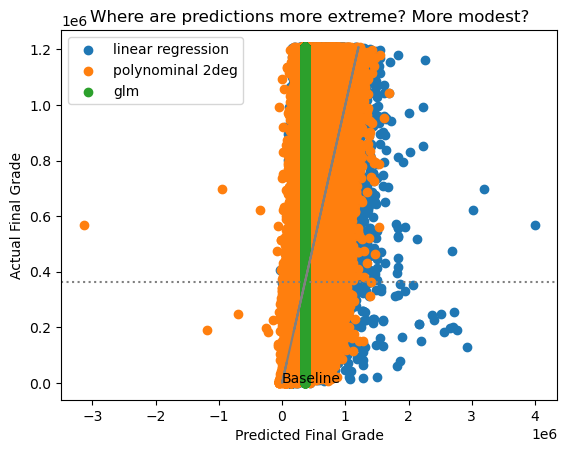

In [72]:
plt.scatter(pred_lr2, y_train, label='linear regression')
plt.scatter(pred_pr, y_train, label='polynominal 2deg')
plt.scatter(pred_glm, y_train, label='glm')
plt.plot(y_train, y_train, label='_nolegend_', color='grey')

plt.axhline(baseline, ls=':', color='grey')
plt.annotate("Baseline", (65, 81))

plt.title("Where are predictions more extreme? More modest?")
plt.ylabel("Actual Final Grade")
plt.xlabel("Predicted Final Grade")
plt.legend()

plt.show()

In [73]:
X_train, X_validate, X_test = wrangle.scaler_min_max(X_train, X_validate, X_test)
metrics_train_df, metrics_validate_df = wrangle.get_model_numbers(X_train, X_validate, X_test, y_train, y_validate, y_test)

In [74]:
metrics_train_df

,model_train,rmse,r2
0,baseline,243873.348212,0.000000
1,ordinary least squared(OLS),205388.273516,0.290712
2,lasso lars(lars),205388.281967,0.290712
3,Polynomial Regression(poly2),202250.639090,0.312217
4,Generalized Linear Model (GLM),245816.043345,-0.015995
